# Figures for the manuscript




In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import SimpleITK as sitk
from pathlib import Path

VLIMS = {
    'abs_error_vmin': 0,       #6.0,    # determined from DB
    'abs_error_vmax': 100,      #41.0,   # determined from DB        # from all error maps we take 97th percentile = 58
    'uq_vmin':        0,       #0.0003, # determined from DB
    'uq_vmax':        0.20,    #0.003,  # determined from DB
}

ROOTS = {
    'kspace':             Path('/scratch/p290820/datasets/003_umcg_pst_ksps'),
    'reader_study':       Path('/scratch/hb-pca-rad/projects/03_reader_set_v2'),
    'reader_study_segs':  Path('/scratch/hb-pca-rad/projects/03_reader_set_v2/segs'),
    'R3_recons_gaussian': Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    'R6_recons_gaussian': Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x"),
    'R3_recons_lxo':      Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/lxo/recons_{3}x"),
    'R6_recons_lxo':      Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/lxo/recons_{6}x"),
    'db_fpath_old':       Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db'),                  # References an OLDER version of the databases where the info could also just be fine that we are looking for
    'db_fpath_new':       Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db'),    # References the LATEST version of the databases where the info could also just be fine that we are looking for
}

FIGDIR = Path(f"/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures")

In [3]:
# Figure 2. Qualitative comparison of error and uncertainty maps.

# Patient High cor      | R1 | R3 | R6 | Err_R3 | Err_R6 | σR3 | σR6
# Patient Moderate cor  | R1 | R3 | R6 | Err_R3 | Err_R6 | σR3 | σR6
# Patient Low cor       | R1 | R3 | R6 | Err_R3 | Err_R6 | σR3 | σR6


In [4]:

lxo_r6_slice_cases = [
    {
        'pat_id': '0033_ANON9728185',
        'slice_idx': 9,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': 0.923969160393271,
        'row_title': 'Subject High cor',
        'row_id': 'A',
        'comment': 'The UQ map shows low UQ indicating a fine recon.'
    },
    {
        'pat_id': '0142_ANON7090827',
        'slice_idx': 22,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': 0.500958650318622,
        'row_title': 'Subject Moderate cor',
        'row_id': 'B',
        'comment': ''
    },
    {
        'pat_id': '0068_ANON7978458',
        'slice_idx': 17,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': 0.0539105638880588,
        'row_title': 'Subject Low cor',
        'row_id': 'C',
        'comment': ''
    }
]

gau_r6_slice_cases = [
    {
        'pat_id': '0107_ANON4035085',
        'slice_idx': 12,
        'acc_factor': 6,
        'uq_method': 'gaussian',
        'region': 'slice',
        'spearman_corr': 0.682220365067812,
        'row_title': 'Subject High cor',
        'row_id': 'A',
        'comment': '',
    },
    {
        'pat_id': '0088_ANON9892116',
        'slice_idx': 13,
        'acc_factor': 6,
        'uq_method': 'gaussian',
        'region': 'slice',
        'spearman_corr': 0.505568183540363,
        'row_title': 'Subject Moderate cor',
        'row_id': 'B',
        'comment': ''
    },
    {
        'pat_id': '0058_ANON9719981',
        'slice_idx': 15,
        'acc_factor': 6,
        'uq_method': 'gaussian',
        'region': 'slice',
        'spearman_corr': 0.13996930321029,
        'row_title': 'Subject Low cor',
        'row_id': 'C',
        'comment': ''
    }
]

qualitative_cases_blurry = [
    {
        'pat_id': '0063_ANON9972960',
        'slice_idx': 10,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': None,
        'row_title': 'Sharpned Prosatte',
        'row_id': 'A',
        'comment': 'DEBLURRING IN PROSTATE ONLY'
    },
    {
        'pat_id': '0047_ANON3613611',
        'slice_idx': 10,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': None,
        'row_title': 'Subject Blurry',
        'row_id': 'B',
        'comment': 'I think the UQ maps show relative certainty because in the R1 just 1 echo train is blurring the data and the UQ map is certain about that. also an artifact is introduced.'
    },
    {
        'pat_id': '0071_ANON9806291',
        'slice_idx': 10,
        'acc_factor': 6,
        'uq_method': 'lxo',
        'region': 'slice',
        'spearman_corr': None,
        'row_title': 'Subject Halucinatory artifact',
        'row_id': 'C',
        'comment': 'This is an example where an artifact became an hallucination (halucinatory artifact).'
    }
]

# Helper functions

In [5]:
# ----------------------------------------------------------------------
# 1. Helper: load & normalise (same adaptive clip you already use)
# ----------------------------------------------------------------------
def load_float(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(str(path))).astype(np.float32)

def normalise(img, clip_percent=99):
    vmax = np.percentile(img, clip_percent)
    return np.clip(img / vmax, 0, 1)

def overlay_sigma(bg, sigma, vmax, cmap='magma', alpha=0.7):
    from matplotlib import cm
    bg_rgb = np.dstack([bg]*3)                     # grey -> RGB
    sigma_norm = np.clip(sigma / vmax, 0, 1)
    color = cm.get_cmap(cmap)(sigma_norm)[..., :3]
    alpha_map = sigma_norm * alpha
    return alpha_map[..., None]*color + (1-alpha_map[..., None])*bg_rgb

# Grid formation

Patient A R3 error min: 0.00, max: 215.00
Patient A R6 error min: 0.00, max: 250.00


/tmp/ipykernel_1520347/2634903298.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap(cmap)(sigma_norm)[..., :3]


Patient B R3 error min: 0.00, max: 299.00
Patient B R6 error min: 0.00, max: 231.00
Patient C R3 error min: 0.00, max: 371.00
Patient C R6 error min: 0.00, max: 322.00


/tmp/ipykernel_1520347/1783662524.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.9,0.97])


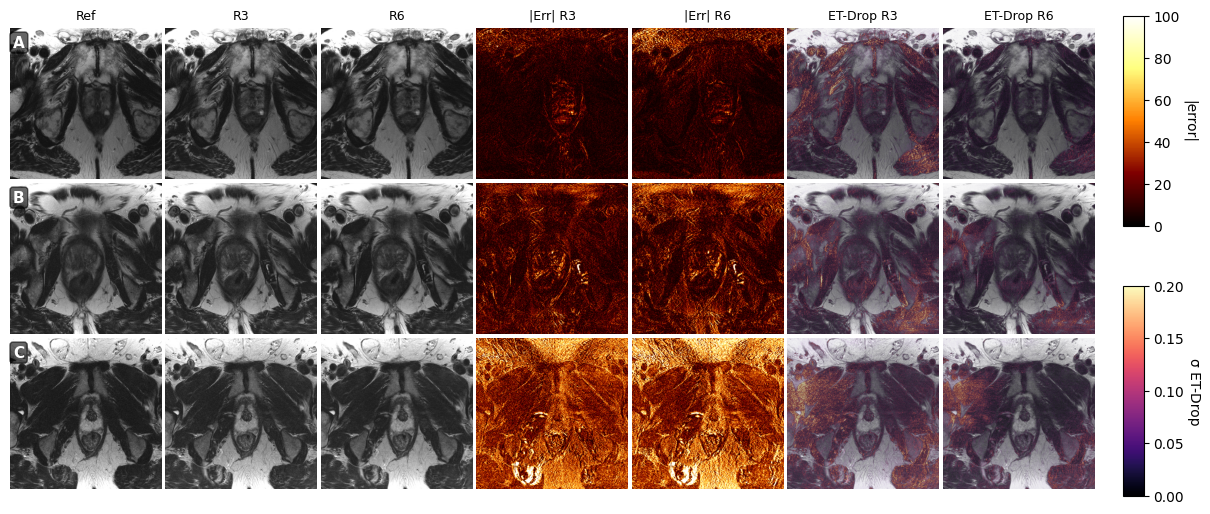

In [6]:
# ---------------------------------------------------------------------------------
# Qualitative grid: three correlation percentiles × seven panels (LXO only)
# ---------------------------------------------------------------------------------

fig_type = "qualitative_cases_blurry"  # lxo_r6_slice_cases

if fig_type == "lxo_r6_slice_cases":
    cases = lxo_r6_slice_cases
elif fig_type == "gau_r6_slice_cases":
    cases = gau_r6_slice_cases
elif fig_type == "qualitative_cases_blurry":
    cases = qualitative_cases_blurry


error_vmax = VLIMS['abs_error_vmax']   # supplied in your notebook
sigma_vmax = VLIMS['uq_vmax']

# ----------------------------------------------------------------------
# 3. Build the 3×7 figure
# ----------------------------------------------------------------------
fig = plt.figure(figsize=(14, 6))                # ~17 cm width at 300 dpi
grid = gs.GridSpec(3, 7, wspace=0.02, hspace=0.02)

for row, case in enumerate(cases):               # cases list you provided
    pid   = case['pat_id']
    sl    = case['slice_idx']

    # ------- load volumes -------
    p_root = ROOTS['reader_study'] / pid
    ref    = load_float(p_root / f"{pid}_rss_target_dcml.mha")
    r3     = load_float(p_root / f"{pid}_VSharp_R3_recon_dcml.mha")
    r6     = load_float(p_root / f"{pid}_VSharp_R6_recon_dcml.mha")

    err3   = np.abs(ref - r3)
    err6   = np.abs(ref - r6)

    # Nicely print the min and max of each error map
    print(f"Patient {case['row_id']} R3 error min: {np.min(err3):.2f}, max: {np.max(err3):.2f}")
    print(f"Patient {case['row_id']} R6 error min: {np.min(err6):.2f}, max: {np.max(err6):.2f}")

    uq_r3 = load_float(ROOTS['R3_recons_lxo'] / pid / f"uq_map_R3_lxo.nii.gz")
    uq_r6 = load_float(ROOTS['R6_recons_lxo'] / pid / f"uq_map_R6_lxo.nii.gz")

    # ------- normalise anatomy for overlay -------
    ref_n = normalise(ref, 97)
    r3_n  = normalise(r3, 97)
    r6_n  = normalise(r6, 97)

    # ------- prepare panels (same order every row) -------
    panels = [
        ref_n[sl],                                             # R1
        r3_n [sl],                                             # R3 recon
        r6_n [sl],                                             # R6 recon
        np.clip(err3[sl] / error_vmax, 0, 1),                  # |Err| R3
        np.clip(err6[sl] / error_vmax, 0, 1),                  # |Err| R6
        overlay_sigma(r3_n[sl], uq_r3[sl], sigma_vmax),           # σ R3 overlay
        overlay_sigma(r6_n[sl], uq_r6[sl], sigma_vmax),           # σ R6 overlay
    ]

    col_titles = ["Ref", "R3", "R6", "|Err| R3", "|Err| R6", "ET-Drop R3", "ET-Drop R6"]
    for col, img in enumerate(panels):
        ax = fig.add_subplot(grid[row, col])
        if img.ndim == 2:                      # greyscale
            cmap = 'gray' if col <= 2 else 'afmhot'
            ax.imshow(img, cmap=cmap, vmin=0, vmax=1)
        else:                                  # RGB overlay
            ax.imshow(img)
        ax.axis('off')

        # Column Titles
        if row == 0:
            ax.set_title(col_titles[col], fontsize=9)

        # Add row label to the first column
        if col == 0:
            ax.text(0.02, 0.95, case['row_id'], color='white',
            fontsize=11, fontweight='bold',
            ha='left', va='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.6))

# ----------------------------------------------------------------------
# 4. Two shared colour-bars (error & σ)
# ----------------------------------------------------------------------
cb_ax_err = fig.add_axes([0.92, 0.55, 0.015, 0.35])   # top bar
cb_ax_sig = fig.add_axes([0.92, 0.10, 0.015, 0.35])   # bottom bar

# |error| 0‒vmax (afmhot)
plt.colorbar(
    plt.cm.ScalarMappable(cmap='afmhot',
                          norm=plt.Normalize(0, error_vmax)),
    cax=cb_ax_err
).set_label('|error|', rotation=270, labelpad=12)

# σ 0‒vmax (magma)
plt.colorbar(
    plt.cm.ScalarMappable(cmap='magma',
                          norm=plt.Normalize(0, sigma_vmax)),
    cax=cb_ax_sig
).set_label('σ ET-Drop', rotation=270, labelpad=12)

# fig.suptitle('Qualitative comparison of ET-Drop uncertainty vs. error at R = 3 and R = 6',
#              y=0.99, fontsize=11)
fig.tight_layout(rect=[0,0,0.9,0.97])

fig.savefig(FIGDIR / Path(f'fig2_qualitative_grid_{fig_type}_big.png'), dpi=300)
plt.show()


# Same grid but then without R3 at all


/tmp/ipykernel_1520347/2634903298.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = cm.get_cmap(cmap)(sigma_norm)[..., :3]
/tmp/ipykernel_1520347/714202858.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0)                           # 1


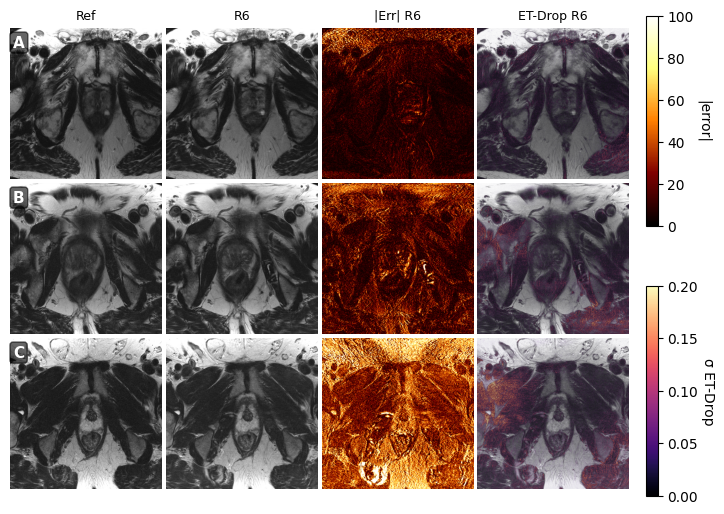

In [15]:
# ---------------------------------------------------------------------------------
# Qualitative grid: three slices × four panels (R = 6 only, ET-Drop)
# ---------------------------------------------------------------------------------

fig_type = "qualitative_cases_blurry"
cases     = qualitative_cases_blurry                # ← you defined this list
error_vmax = VLIMS['abs_error_vmax']
sigma_vmax = VLIMS['uq_vmax']

# ----------------------------------------------------------------------
# 1.  Figure canvas: 3 rows × 4 columns
# ----------------------------------------------------------------------
fig  = plt.figure(figsize=(8, 6))                  # narrower width
grid = gs.GridSpec(3, 4, wspace=0.02, hspace=0.02)  # 4 columns now

col_titles = ["Ref", "R6", "|Err| R6", "ET-Drop R6"]

for row, case in enumerate(cases):
    pid, sl = case['pat_id'], case['slice_idx']

    # ----- load images -----
    p_root = ROOTS['reader_study'] / pid
    ref    = load_float(p_root / f"{pid}_rss_target_dcml.mha")
    r6     = load_float(p_root / f"{pid}_VSharp_R6_recon_dcml.mha")
    err6   = np.abs(ref - r6)

    uq_r6  = load_float(ROOTS['R6_recons_lxo'] / pid / f"uq_map_R6_lxo.nii.gz")

    # ----- normalise anatomy for overlay -----
    ref_n = normalise(ref, 97)
    r6_n  = normalise(r6 , 97)

    panels = [
        ref_n[sl],                                     # column 0
        r6_n [sl],                                     # column 1
        np.clip(err6[sl] / error_vmax, 0, 1),          # column 2
        overlay_sigma(r6_n[sl], uq_r6[sl], sigma_vmax) # column 3
    ]

    # ------------------------------------------------------------------
    # 2.  Populate the grid
    # ------------------------------------------------------------------
    for col, img in enumerate(panels):
        ax = fig.add_subplot(grid[row, col])

        if img.ndim == 2:                 # greyscale or error map
            cmap = 'gray' if col <= 1 else 'afmhot'
            ax.imshow(img, cmap=cmap, vmin=0, vmax=1)
        else:                             # RGB overlay
            ax.imshow(img)

        ax.axis('off')

        if row == 0:                      # header row
            ax.set_title(col_titles[col], fontsize=9)

        if col == 0:                      # row label (A/B/C)
            ax.text(0.02, 0.95, case['row_id'], color='white',
                    fontsize=11, fontweight='bold', ha='left', va='top',
                    transform=ax.transAxes,
                    bbox=dict(boxstyle='round,pad=0.2',
                              fc='black', alpha=0.6))

# ----------------------------------------------------------------------
# 3.  Shared colour bars
# ----------------------------------------------------------------------
cb_ax_err = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cb_ax_sig = fig.add_axes([0.92, 0.10, 0.015, 0.35])

plt.colorbar(plt.cm.ScalarMappable(cmap='afmhot',
                                   norm=plt.Normalize(0, error_vmax)),
             cax=cb_ax_err).set_label('|error|', rotation=270, labelpad=12)

plt.colorbar(plt.cm.ScalarMappable(cmap='magma',
                                   norm=plt.Normalize(0, sigma_vmax)),
             cax=cb_ax_sig).set_label('σ ET-Drop', rotation=270, labelpad=12)

# fig.tight_layout(rect=[0, 0, 0.9, 0.97])
fig.tight_layout(pad=0)                           # 1
fig.savefig(FIGDIR / 'fig2_R6_only.png',          # 2
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)
fig.savefig(FIGDIR / 'fig2_qualitative_grid_R6_only.png', dpi=300)
plt.show()


# Error map calculation and write to file


Processing patient 0003_ANON5046358 with acceleration factor 3...
Processing patient 0003_ANON5046358 with acceleration factor 6...
Processing patient 0004_ANON9616598 with acceleration factor 3...
Processing patient 0004_ANON9616598 with acceleration factor 6...
Processing patient 0005_ANON8290811 with acceleration factor 3...
Processing patient 0005_ANON8290811 with acceleration factor 6...
Processing patient 0006_ANON2379607 with acceleration factor 3...
Processing patient 0006_ANON2379607 with acceleration factor 6...
Processing patient 0007_ANON1586301 with acceleration factor 3...
Processing patient 0007_ANON1586301 with acceleration factor 6...
Processing patient 0008_ANON8890538 with acceleration factor 3...
Processing patient 0008_ANON8890538 with acceleration factor 6...
Processing patient 0010_ANON7748752 with acceleration factor 3...
Processing patient 0010_ANON7748752 with acceleration factor 6...
Processing patient 0011_ANON1102778 with acceleration factor 3...
Processing

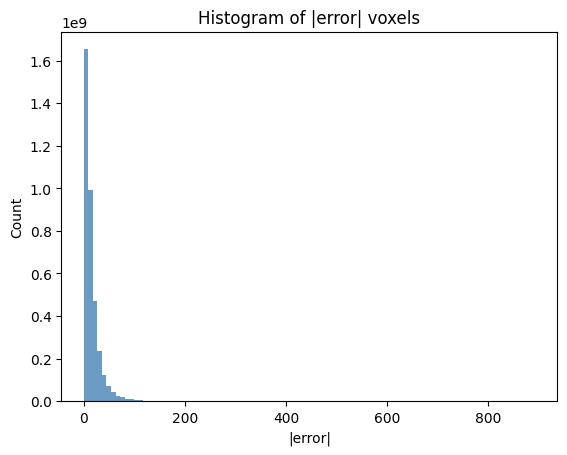

In [40]:
# All patient IDs to consider for Uncertainty Quantification
PAT_IDS = [
        '0003_ANON5046358',
        '0004_ANON9616598',
        '0005_ANON8290811',
        '0006_ANON2379607',
        '0007_ANON1586301',     # with lesions I think for testing.
        '0008_ANON8890538',
        '0010_ANON7748752',
        '0011_ANON1102778',
        '0012_ANON4982869',
        '0013_ANON7362087',
        '0014_ANON3951049',
        '0015_ANON9844606',
        '0018_ANON9843837',
        '0019_ANON7657657',
        '0020_ANON1562419',
        '0021_ANON4277586',
        '0023_ANON6964611',
        '0024_ANON7992094',
        '0026_ANON3620419',
        '0027_ANON9724912',   # here is 20
        '0028_ANON3394777',
        '0029_ANON7189994',
        '0030_ANON3397001',
        '0031_ANON9141039',
        '0032_ANON7649583',
        '0033_ANON9728185',
        '0035_ANON3474225',
        '0036_ANON0282755',
        '0037_ANON0369080',
        '0039_ANON0604912',
        '0042_ANON9423619',
        '0043_ANON7041133',
        '0044_ANON8232550',
        '0045_ANON2563804',
        '0047_ANON3613611',
        '0048_ANON6365688',
        '0049_ANON9783006',
        '0051_ANON1327674',
        '0052_ANON9710044',
        '0053_ANON5517301',
        '0055_ANON3357872',
        '0056_ANON2124757',
        '0057_ANON1070291',
        '0058_ANON9719981',
        '0059_ANON7955208',
        '0061_ANON7642254',
        '0062_ANON0319974',
        '0063_ANON9972960',
        '0064_ANON0282398',
        '0067_ANON0913099',
        '0068_ANON7978458',
        '0069_ANON9840567',
        '0070_ANON5223499',
        '0071_ANON9806291',
        '0073_ANON5954143',
        '0075_ANON5895496',
        '0076_ANON3983890',
        '0077_ANON8634437',
        '0078_ANON6883869',
        '0079_ANON8828023',
        '0080_ANON4499321',
        '0081_ANON9763928',
        '0082_ANON6073234',
        '0083_ANON9898497',
        '0084_ANON6141178',
        '0085_ANON4535412',
        '0086_ANON8511628',
        '0087_ANON9534873',
        '0088_ANON9892116',
        '0089_ANON9786899',
        '0090_ANON0891692',
        '0092_ANON9941969',
        '0093_ANON9728761',
        '0094_ANON8024204',
        '0095_ANON4189062',
        '0097_ANON5642073',
        '0103_ANON8583296',
        '0104_ANON7748630',
        '0105_ANON9883201',
        '0107_ANON4035085',
        '0108_ANON0424679',
        '0109_ANON9816976',
        '0110_ANON8266491',
        '0111_ANON9310466',
        '0112_ANON3210850',
        '0113_ANON9665113',
        '0115_ANON0400743',
        '0116_ANON9223478',
        #'0118_ANON7141024',       We skip this patient because the LXO method does not seem to work for it on R6
        '0119_ANON3865800',
        '0120_ANON7275574',
        '0121_ANON9629161',
        '0123_ANON7265874',
        '0124_ANON8610762',
        '0125_ANON0272089',
        '0126_ANON4747182',
        '0127_ANON8023509',
        '0128_ANON8627051',
        '0129_ANON5344332',
        '0135_ANON9879440',
        '0136_ANON8096961',
        '0137_ANON8035619',
        '0138_ANON1747790',
        '0139_ANON2666319',
        '0140_ANON0899488',
        '0141_ANON8018038',
        '0142_ANON7090827',
        '0143_ANON9752849',
        '0144_ANON2255419',
        '0145_ANON0335209',
        '0146_ANON7414571',
        '0148_ANON9604223',
        '0149_ANON4712664',
        '0150_ANON5824292',
        '0152_ANON2411221',
        '0153_ANON5958718',
        '0155_ANON7828652',
        '0157_ANON9873056',
        '0159_ANON9720717',
        '0160_ANON3504149'
    ]

# lets keep track of all the error values in the entire dataset.
all_err_vox = []  # List to store error values for all patients and acceleration factors

# === Configurable Params ===
ACC_FACTORS       = [3, 6]                          # Define the set of acceleration factors we care about.

# Iterate over patients and acceleration factors
for pat_id in PAT_IDS:
    pat_dir  = ROOTS['reader_study'] / pat_id
    ref_img  = sitk.ReadImage(str(pat_dir / f"{pat_id}_rss_target_dcml.mha"))
    ref      = sitk.GetArrayFromImage(ref_img).astype('float32')

    for r in ACC_FACTORS:
        print(f"Processing patient {pat_id} with acceleration factor {r}...")
        rec_path = pat_dir / f"{pat_id}_VSharp_R{r}_recon_dcml.mha"
        assert rec_path.exists(), f"Reconstruction file not found: {rec_path}"

        rec  = sitk.GetArrayFromImage(sitk.ReadImage(str(rec_path))).astype('float32')
        err  = np.abs(ref - rec)

        # save error map next to recon
        err_img = sitk.GetImageFromArray(err); err_img.CopyInformation(ref_img)
        sitk.WriteImage(err_img, str(pat_dir / f"{pat_id}_error_R{r}.mha"))

        all_err_vox.append(err.ravel())          # accumulate for percentiles

# -------- percentiles 80–99 --------
err_vec = np.concatenate(all_err_vox)
for p, val in zip(range(80, 100), np.percentile(err_vec, range(80, 100))):
    print(f"{p}th percentile: {val:.2f}")

# -------- optional histogram --------
plt.hist(err_vec, bins=100, color='steelblue', alpha=0.8)
plt.title("Histogram of |error| voxels"); plt.xlabel("|error|"); plt.ylabel("Count")
plt.show()

Of all the error maps from all patients we get the following error map percentiles:
- 80th percentile: 22.00
- 81th percentile: 23.00
- 82th percentile: 24.00
- 83th percentile: 25.00
- 84th percentile: 26.00
- 85th percentile: 27.00
- 86th percentile: 28.00
- 87th percentile: 29.00
- 88th percentile: 30.00
- 89th percentile: 32.00
- 90th percentile: 34.00
- 91th percentile: 35.00
- 92th percentile: 38.00
- 93th percentile: 40.00
- 94th percentile: 43.00
- 95th percentile: 47.00
- 96th percentile: 51.00
- 97th percentile: 58.00
- 98th percentile: 68.00
- 99th percentile: 87.00